# Modeling

In this notebook I will build **models to predict the student course outcome.** In previous notebook **EDA** I've performed the **exploratory analysis and built some visualizations**. At the end, the new dataset was stored as "final_data.csv" file in data folder.

## Goal of the Modeling
The main goal of the project is to be able to predict the outcome of the students in the course. I will build different algorithms of **multiclass classification models and evaluate their performance**. At the end of the notebook I will choose a model that has the **most appropriate parameters and performed the best.**

## Import Packages

Import standard libraries and necessary packages for transformation, modeling and evaluation. In addition, import user defined functions and classess.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.cluster import KMeans
from xgboost import XGBClassifier as XGB


from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.inspection import permutation_importance

import warnings

# Import additional files with user-defined statistical functions
import sys
import os

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import explore_data as ed 
import model_functions as mf
import model_history as mh

* Set notebook's visual parameters

In [2]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

plt.style.use('seaborn-dark')
sns.set_theme('talk')

## Upload Dataset

Upload **final_data.csv** from data folder, keep **id_student** feature **as object type.**

In [3]:
df = pd.read_csv('../../data/final_data.csv', dtype={"id_student": str})

In [4]:
ed.show_info(df)

Lenght of Dataset: 20224
                            missing_values_% Data_type
module_presentation_length               0.0     int64
code_module                              0.0    object
code_presentation                        0.0    object
id_student                               0.0    object
date_registration                        0.0     int64
sum_click                                0.0     int64
gender                                   0.0    object
region                                   0.0    object
highest_education                        0.0    object
imd_band                                 0.0    object
age_band                                 0.0    object
num_of_prev_attempts                     0.0     int64
studied_credits                          0.0     int64
disability                               0.0    object
final_result                             0.0    object
mean_score                               0.0   float64


* I will **drop** columns that are not relevant to modeling, such that **id_student and code_presentation**.

In [5]:
df.drop(columns = ['id_student', 'code_presentation'], inplace = True)

In [6]:
df.rename(columns = {'module_presentation_length': 'course_length', 
                     'num_of_prev_attempts': 'attempts'}, inplace = True)
df.head()

,course_length,code_module,date_registration,sum_click,gender,region,highest_education,imd_band,age_band,attempts,studied_credits,disability,final_result,mean_score
0,262,DDD,88,458,M,North Western Region,Lower Than A Level,0-10%,0-35,0,60,N,Pass,86.50
1,262,DDD,136,1107,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,80.00
2,262,DDD,107,663,M,West Midlands Region,A Level or Equivalent,90-100%,0-35,0,60,N,Pass,86.00
3,262,DDD,99,729,M,East Anglian Region,A Level or Equivalent,80-90%,0-35,0,90,N,Fail,65.25
4,262,DDD,143,453,F,South Region,A Level or Equivalent,40-50%,0-35,0,60,Y,Pass,87.50


## Features

* **course_length:** length of the code_module in days.
* **code_module:** three letter id of the course.
* **date_registration:** number of days student registered before the course beginning.
* **sum_click:** sum of click student made on Vle for given course.
* **gender:** gender of the student.
* **region:** region of student location in UK.
* **highest_education:** education level of the student.
* **imd_band:** indices of multiple deprivation - a measure of economic status.
* **age_band:** age category of the student.
* **attempts:** number of times the student has attempted the class.
* **disability:** disability status of the student.
* **studied credits:** number of credits student acquired by the begginning of the course.
* **mean_score:** The student's mean assessment score.


### Binarize Classes

* For the purpose of modeling, I will binarize the target labels, such that Fail/Withdraw - 1, and Pass/Distinc - 0.

In [7]:
df['final_result'] = df['final_result'].apply(lambda x: 0 if ('Pass' in x or 'Distinct' in x ) else 1)
df['final_result'].value_counts()

0    14628
1     5596
Name: final_result, dtype: int64

* Classes are imbalanced.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20224 entries, 0 to 20223
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_length      20224 non-null  int64  
 1   code_module        20224 non-null  object 
 2   date_registration  20224 non-null  int64  
 3   sum_click          20224 non-null  int64  
 4   gender             20224 non-null  object 
 5   region             20224 non-null  object 
 6   highest_education  20224 non-null  object 
 7   imd_band           20224 non-null  object 
 8   age_band           20224 non-null  object 
 9   attempts           20224 non-null  int64  
 10  studied_credits    20224 non-null  int64  
 11  disability         20224 non-null  object 
 12  final_result       20224 non-null  int64  
 13  mean_score         20224 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 2.2+ MB


## Feature Correlation

Explore how correlated numeric features are.

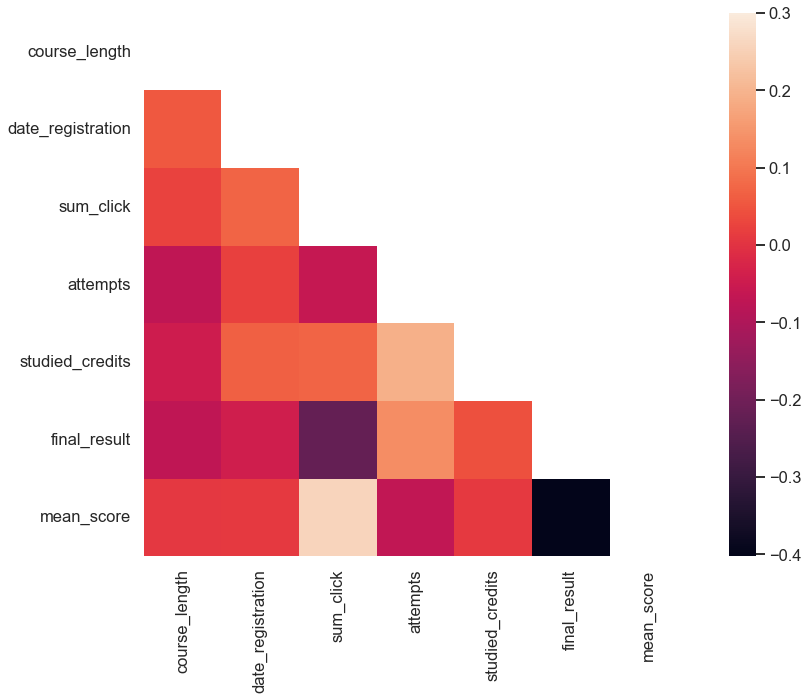

In [9]:
corr = df.corr(method = 'pearson')

mask = np.triu(np.ones_like(corr, dtype='bool'))

with sns.axes_style("white"):
    f,ax = plt.subplots(figsize = (15,10))
    ax = sns.heatmap(corr, mask = mask, vmax = 0.3, square = True)

In [10]:
corr_matrix = df.corr()
corr_mat = corr_matrix["final_result"].sort_values(ascending=False)
print(corr_mat)

final_result         1.000000
attempts             0.132633
studied_credits      0.044604
date_registration   -0.042975
course_length       -0.072593
sum_click           -0.220464
mean_score          -0.402654
Name: final_result, dtype: float64


<AxesSubplot:xlabel='mean_score', ylabel='final_result'>

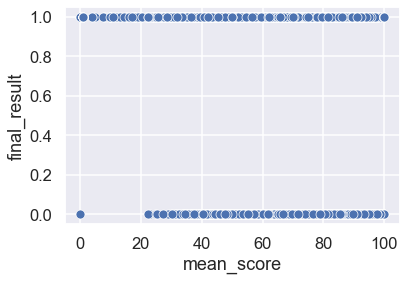

In [11]:
sns.scatterplot(data=df, x="mean_score", y="final_result")

### Train-Test Split

To prevent models from **overfitting** and to be able to **accurately evaluate model** I will split the data to **X as a features and y as a target variable, and split data into three sets: train, test and holdout.**

In [12]:
X = df.drop("final_result", axis=1)
y = df['final_result']

Now, split the data to **train and holdout sets** and then **split the train set into test and train sets too.**

In [13]:
x_all, x_hold, y_all, y_hold = train_test_split(X, y, train_size = 0.80, random_state=2021)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, train_size = 0.75,random_state=2021)

### Data Imbalance

I will check how balanced my train data is based on target feature

In [14]:
pd.Series(y_train).value_counts(normalize=True)

0    0.720949
1    0.279051
Name: final_result, dtype: float64

* It is clear that train set is imbalanced. I will build first model with this data and later on try to balance it using SMOTE.

In [15]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12134 entries, 1739 to 5312
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_length      12134 non-null  int64  
 1   code_module        12134 non-null  object 
 2   date_registration  12134 non-null  int64  
 3   sum_click          12134 non-null  int64  
 4   gender             12134 non-null  object 
 5   region             12134 non-null  object 
 6   highest_education  12134 non-null  object 
 7   imd_band           12134 non-null  object 
 8   age_band           12134 non-null  object 
 9   attempts           12134 non-null  int64  
 10  studied_credits    12134 non-null  int64  
 11  disability         12134 non-null  object 
 12  mean_score         12134 non-null  float64
dtypes: float64(1), int64(5), object(7)
memory usage: 1.3+ MB


## Baseline Model - Logistic Regression

### ColumnTransformer for Categorical Features

Before I start any modeling, I will use **ColumnTransformer and OneHotEncode** all categorical features of the dataframe:

In [16]:
cat_cols = x_train.select_dtypes(include='object').columns
indices = []
for col in cat_cols:
    indices.append(x_train.columns.get_loc(col))
indices

[1, 4, 5, 6, 7, 8, 11]

In [17]:
transformer = ColumnTransformer(transformers=[('categorical', 
                                               OneHotEncoder(handle_unknown = 'ignore'), indices)], 
                                remainder = 'passthrough')

### Build Logistic Regression Pipeline

* The pipeline will apply following transformers: ColumnTransformer, StandardScaler.

In [18]:
base_model_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                               LR(C=0.01, random_state=2021, max_iter = 5000))

base_model_pipe.fit(x_train, y_train)
base_model_pipe.score(x_test, y_test)

history = mh.ModelHistory()

In [19]:
history.report(base_model_pipe,x_train, y_train, 'Logistic Regression', 
               'Regression with All Features and Imbalanced Data')

Average Accuracy Score: 0.7804530409851539
Average Recall Score: 0.3983748088897073
Average Precision Score: 0.6819532673637891
Average F1 Score: 0.5024905647920963


* **Get predictions for both train and test splits.**

In [20]:
train_preds = base_model_pipe.predict(x_train)
test_preds = base_model_pipe.predict(x_test)

* **Print out evaluation metrics by calling user defined function**

In [21]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.6864321608040201
Recall Score: 0.40342587123449497
Accuracy Score: 0.7820998846217241
F1 Score: 0.5081845238095237


Precision Score: 0.6597325408618128
Recall Score: 0.3918799646954987
Accuracy Score: 0.773053152039555
F1 Score: 0.49169435215946844




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

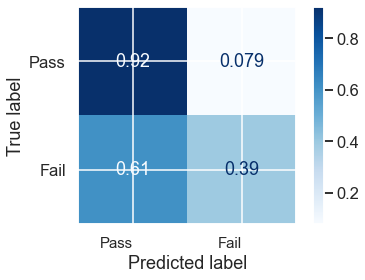

In [22]:
mf.confusion_mtx(base_model_pipe, x_test, y_test)


In [23]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     9490
False    2644
Name: final_result, dtype: int64


In [24]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     3127
False     918
Name: final_result, dtype: int64


**Model Results:**
* Model is overfitting train set. 
* From confusion matrix it is clear that model predicting most of the outcomes as "Pass", due to class imbalance
* About 1/3 of outcomes of test data were predicted falsely based on residuals

## Logistic Regression with Upsampled Data

Since the classes of the target are imbalanced, I will use **SMOTE()** in the pipeline **to upsample data.**

In [25]:
upsample_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                              SMOTE(random_state = 2021), 
                              LR(C=0.01, random_state=2021, max_iter = 5000))

upsample_pipe.fit(x_train, y_train)

history.report(upsample_pipe,x_train, y_train, 'Logistic Regression', 
               'Logistic Regression with Upsampled Data')

Average Accuracy Score: 0.733558470767672
Average Recall Score: 0.7105936715774724
Average Precision Score: 0.5163829966986826
Average F1 Score: 0.5979641622955632


* **Get predicted values for train and test splits**

In [26]:
train_preds = upsample_pipe.predict(x_train)
test_preds = upsample_pipe.predict(x_test)

* **Evaluation Metrics**

In [27]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5222724338282763
Recall Score: 0.716774955699941
Accuracy Score: 0.7380089006098566
F1 Score: 0.6042574380679696


Precision Score: 0.5218811234487263
Recall Score: 0.705207413945278
Accuracy Score: 0.7364647713226206
F1 Score: 0.5998498498498498




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

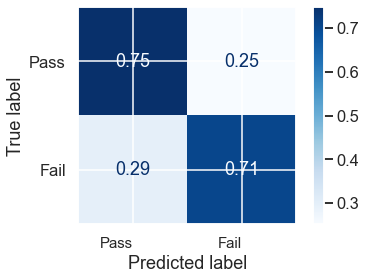

In [28]:
mf.confusion_mtx(upsample_pipe, x_test, y_test)

In [29]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     8955
False    3179
Name: final_result, dtype: int64


In [30]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2979
False    1066
Name: final_result, dtype: int64


**Model Results:**

* Upsampled model performed better than imbalanced data in terms of evaluation metrics - the recall score got higher
* The confusion matrix shows better performance in term of high diagonal values.
* The value of false negatives went down

## Grid Search for C Value

In [31]:
C = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

parameters = dict(logisticregression__C=C)

clf_GS = GridSearchCV(upsample_pipe, parameters)

clf_GS.fit(x_train, y_train)


print('Best C:', clf_GS.best_estimator_.get_params()['logisticregression__C'])

Best C: 1.0


In [32]:
lr_best_c_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), SMOTE(),
                              LR(C=clf_GS.best_estimator_.get_params()['logisticregression__C'],
                                                 random_state=2021, max_iter = 5000))
lr_best_c_pipe.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [1, 4, 5, 6, 7, 8, 11])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('smote', SMOTE()),
                ('logisticregression',
                 LogisticRegression(max_iter=5000, random_state=2021))])

In [33]:
history.report(lr_best_c_pipe,x_train, y_train, 'Logistic Regression', 
               'Regression with All Features and Best C - Value')

Average Accuracy Score: 0.7347124302755297
Average Recall Score: 0.713875334302383
Average Precision Score: 0.517823800296466
Average F1 Score: 0.600099609578151


In [34]:
train_preds = lr_best_c_pipe.predict(x_train)
test_preds = lr_best_c_pipe.predict(x_test)

In [35]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5194331114451364
Recall Score: 0.7144122858830478
Accuracy Score: 0.7358661611999341
F1 Score: 0.6015168469476564


Precision Score: 0.5217109526895658
Recall Score: 0.7105030891438658
Accuracy Score: 0.7364647713226206
F1 Score: 0.601644245142003




<Figure size 720x720 with 0 Axes>

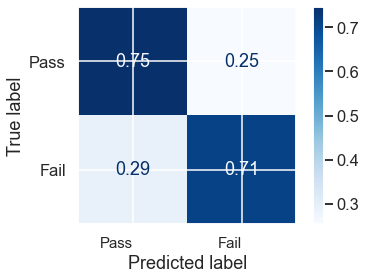

In [36]:
mf.confusion_mtx(lr_best_c_pipe, x_test, y_test)

### Model Results:
* Model Performed same as Upsampled Logistic Regression in terms of metrics
* Confusion Matrix shows higher value for false negatives

## K Nearest Neighbors

In [37]:
knn_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), KNN())

knn_pipeline.fit(x_train, y_train)
knn_pipeline.score(x_test, y_test)

0.6029666254635352

In [38]:
history.report(knn_pipeline,x_train, y_train, 'KNN - Defaults', 
               'KNN with All Features')

Average Accuracy Score: 0.5956784749508006
Average Recall Score: 0.577538705563644
Average Precision Score: 0.3601907210941548
Average F1 Score: 0.4435882708351775


* **Get predicted values for the train and test splits**

In [39]:
train_preds = knn_pipeline.predict(x_train)
test_preds = knn_pipeline.predict(x_test)

* **Evaluation Metrics**

In [40]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5619819140919367
Recall Score: 0.8809805079740106
Accuracy Score: 0.7751771880665898
F1 Score: 0.6862203818725559


Precision Score: 0.36780324203465625
Recall Score: 0.5807590467784642
Accuracy Score: 0.6029666254635352
F1 Score: 0.4503764544832307




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

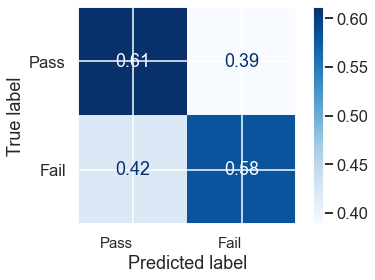

In [41]:
mf.confusion_mtx(knn_pipeline, x_test, y_test)

In [42]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     9406
False    2728
Name: final_result, dtype: int64


In [43]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2439
False    1606
Name: final_result, dtype: int64


### Model Results:
* Model is overfitting training data based on metrics
* Confusion matrix on test sets shows increased value for false negatives

## Decision Tree Model

In [44]:
dt_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT(random_state = 2021))

In [45]:
dt_pipeline.fit(x_train, y_train)
dt_pipeline.score(x_test, y_test)

0.6964153275648949

In [46]:
history.report(dt_pipeline,x_train, y_train, 'Decision Tree - Defaults', 
               'Decision Tree with All Features')

Average Accuracy Score: 0.7136158122264159
Average Recall Score: 0.562661932566621
Average Precision Score: 0.4885617963135574
Average F1 Score: 0.5228656153267235


* **Predicted Values**

In [47]:
train_preds = dt_pipeline.predict(x_train)
test_preds = dt_pipeline.predict(x_test)

* **Evaluation Metrics**

In [48]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
F1 Score: 1.0


Precision Score: 0.4630924630924631
Recall Score: 0.5260370697263901
Accuracy Score: 0.6964153275648949
F1 Score: 0.4925619834710743




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

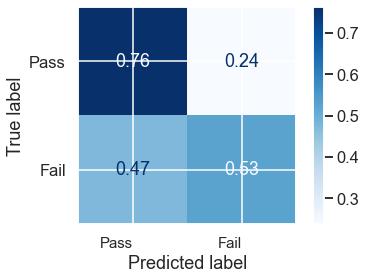

In [49]:
mf.confusion_mtx(dt_pipeline, x_test, y_test)

In [50]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True    12134
Name: final_result, dtype: int64


In [51]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2817
False    1228
Name: final_result, dtype: int64


* Model is overfitting training data

### Max Depth of Tree

I will use the AUC and ROC to identify optimal depth of the tree.

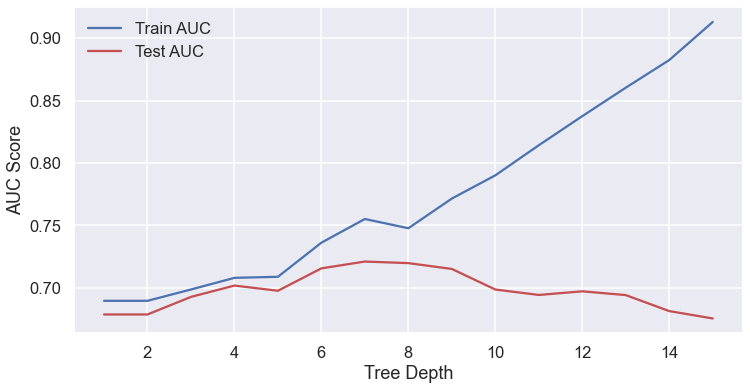

In [52]:
max_depths = np.linspace(1, 15, 15, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    
    dt_depth_p = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT( max_depth=max_depth,
                                         random_state = 1))
    dt_depth_p.fit(x_train, y_train)
    train_pred = dt_depth_p.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt_depth_p.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.legend()
plt.show()

In [53]:
# Max depth 5 or 7

In [54]:
dt_pipe_2 = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT(random_state = 2021, max_depth = 5))

In [55]:
dt_pipe_2.fit(x_train, y_train)
dt_pipe_2.score(x_test, y_test)

0.7273176761433869

In [56]:
history.report(dt_pipe_2,x_train, y_train, 'Decision Tree - Depth 5', 
               'Decision Tree with Max Depth of 5')

Average Accuracy Score: 0.7330627428557459
Average Recall Score: 0.6458902661822693
Average Precision Score: 0.5219079834704001
Average F1 Score: 0.5749286297097141


* **Predicted Values**

In [57]:
train_preds = dt_pipe_2.predict(x_train)
test_preds = dt_pipe_2.predict(x_test)

* **Evaluation Metrics**

In [58]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5233644859813084
Recall Score: 0.6780862374483166
Accuracy Score: 0.737844074501401
F1 Score: 0.5907628972082851


Precision Score: 0.5101626016260162
Recall Score: 0.6646072374227714
Accuracy Score: 0.7273176761433869
F1 Score: 0.5772326561901111




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

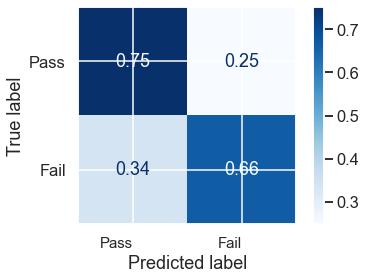

In [59]:
mf.confusion_mtx(dt_pipe_2, x_test, y_test)

In [60]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     8953
False    3181
Name: final_result, dtype: int64


In [61]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2942
False    1103
Name: final_result, dtype: int64


### Model Results:

* After tuning depth of the tree, the metrics show almost no overfitting.
* The confusion matrix show slightly better results, but still worse than Linear Regression
* The value of false negatives is high.

## Random Forest Model

I will use same depth for Random Forest Model as I used in Decision Tree

In [62]:
rf_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), RFC(max_depth = 5, random_state = 2021))

In [63]:
rf_pipeline.fit(x_train, y_train)
rf_pipeline.score(x_test, y_test)

0.7352286773794808

In [64]:
history.report(rf_pipeline,x_train, y_train, 'Random Forest - Depth 5', 
               'Random Forest with All Features and Depth 5')

Average Accuracy Score: 0.7334756909971736
Average Recall Score: 0.6536680891508873
Average Precision Score: 0.517595792714926
Average F1 Score: 0.5775969413250598


* **Predicted Values**

In [65]:
train_preds = rf_pipeline.predict(x_train)
test_preds = rf_pipeline.predict(x_test)

* **Evaluation Metrics**

In [66]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5297998180163785
Recall Score: 0.6878322504430006
Accuracy Score: 0.742541618592385
F1 Score: 0.5985607812901568


Precision Score: 0.5214681440443213
Recall Score: 0.6646072374227714
Accuracy Score: 0.7352286773794808
F1 Score: 0.5844004656577415




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

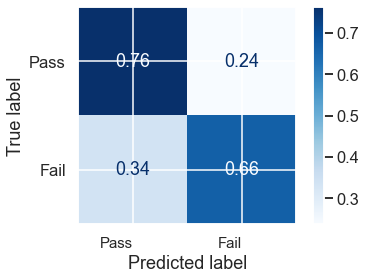

In [67]:
mf.confusion_mtx(rf_pipeline, x_test, y_test)

In [68]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     9010
False    3124
Name: final_result, dtype: int64


In [69]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2974
False    1071
Name: final_result, dtype: int64


### Model Results:

* The metrics show infignificant improvement compared to Decision Tree
* Confusion Matrix has slightly worse values than Decision Tree 

## Gradient Boost

In [70]:
gbc_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), GBC(max_depth = 5, random_state = 2021))

In [71]:
gbc_pipeline.fit(x_train, y_train)
gbc_pipeline.score(x_test, y_test)

0.78442521631644

In [72]:
history.report(gbc_pipeline,x_train, y_train, 'Gradient Boost - Depth 5', 
               'Gradient Boost with All Features and Depth 5')

Average Accuracy Score: 0.7919068004362406
Average Recall Score: 0.5821198850961455
Average Precision Score: 0.639405970821859
Average F1 Score: 0.6093026363899863


* **Predicted Values**

In [73]:
train_preds = gbc_pipeline.predict(x_train)
test_preds = gbc_pipeline.predict(x_test)

* **Evaluation Metrics**

In [74]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.7191939213742979
Recall Score: 0.6429415239220319
Accuracy Score: 0.8303115213449811
F1 Score: 0.6789334164977389


Precision Score: 0.6280667320902846
Recall Score: 0.5648720211827007
Accuracy Score: 0.78442521631644
F1 Score: 0.5947955390334573




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

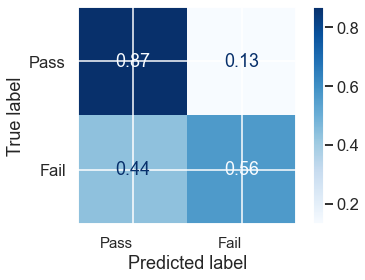

In [75]:
mf.confusion_mtx(gbc_pipeline, x_test, y_test)

In [76]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     10075
False     2059
Name: final_result, dtype: int64


In [77]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     3173
False     872
Name: final_result, dtype: int64


### Model Results:

* Evaluation metrics show that model is overfitting training set
* Confusion matrix has worse results compared to models above

## XGBoost



In [78]:
xgb_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), XGB(use_label_encoder=False, verbosity=0))

In [79]:
xgb_pipeline.fit(x_train, y_train)
xgb_pipeline.score(x_test, y_test)

0.7836835599505563

In [80]:
history.report(xgb_pipeline,x_train, y_train, 'XGBoost - Defaults', 
               'XGBoost with All Features')

Average Accuracy Score: 0.7923201560252672
Average Recall Score: 0.5246660746293275
Average Precision Score: 0.6602852827777601
Average F1 Score: 0.5844614646953629


* **Predicted Values**

In [81]:
train_preds = xgb_pipeline.predict(x_train)
test_preds = xgb_pipeline.predict(x_test)

* **Evaluation Metrics**

In [82]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.8284222305110034
Recall Score: 0.6559362079149439
Accuracy Score: 0.8660787868798417
F1 Score: 0.7321575737596835


Precision Score: 0.6439732142857143
Recall Score: 0.5092674315975286
Accuracy Score: 0.7836835599505563
F1 Score: 0.5687530803351405




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

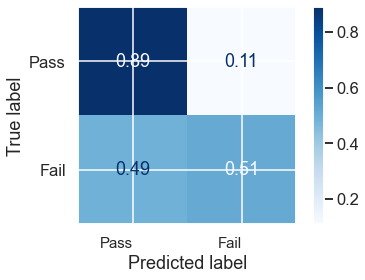

In [83]:
mf.confusion_mtx(xgb_pipeline, x_test, y_test)

In [84]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     10509
False     1625
Name: final_result, dtype: int64


In [85]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     3170
False     875
Name: final_result, dtype: int64


### Model Results:

* Almost the same metric results as for Gradient Boost - overfitting training set
* Worse values for confusion matrix

## Feature Importance Logistic Regression

In [86]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12134 entries, 1739 to 5312
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_length      12134 non-null  int64  
 1   code_module        12134 non-null  object 
 2   date_registration  12134 non-null  int64  
 3   sum_click          12134 non-null  int64  
 4   gender             12134 non-null  object 
 5   region             12134 non-null  object 
 6   highest_education  12134 non-null  object 
 7   imd_band           12134 non-null  object 
 8   age_band           12134 non-null  object 
 9   attempts           12134 non-null  int64  
 10  studied_credits    12134 non-null  int64  
 11  disability         12134 non-null  object 
 12  mean_score         12134 non-null  float64
dtypes: float64(1), int64(5), object(7)
memory usage: 1.3+ MB


In [87]:
num_vars = ['course_length', 'date_registration', 'sum_click', 'attempts', 'studied_credits', 'mean_score']

cat_vars = upsample_pipe.named_steps['columntransformer'].transformers_[0][1].get_feature_names().tolist()

features_df = list(zip(num_vars + cat_vars, upsample_pipe.named_steps['logisticregression'].coef_[0]))

In [88]:
feature_importance = pd.DataFrame(features_df, columns = ["feature", "importance"])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)

<BarContainer object of 48 artists>

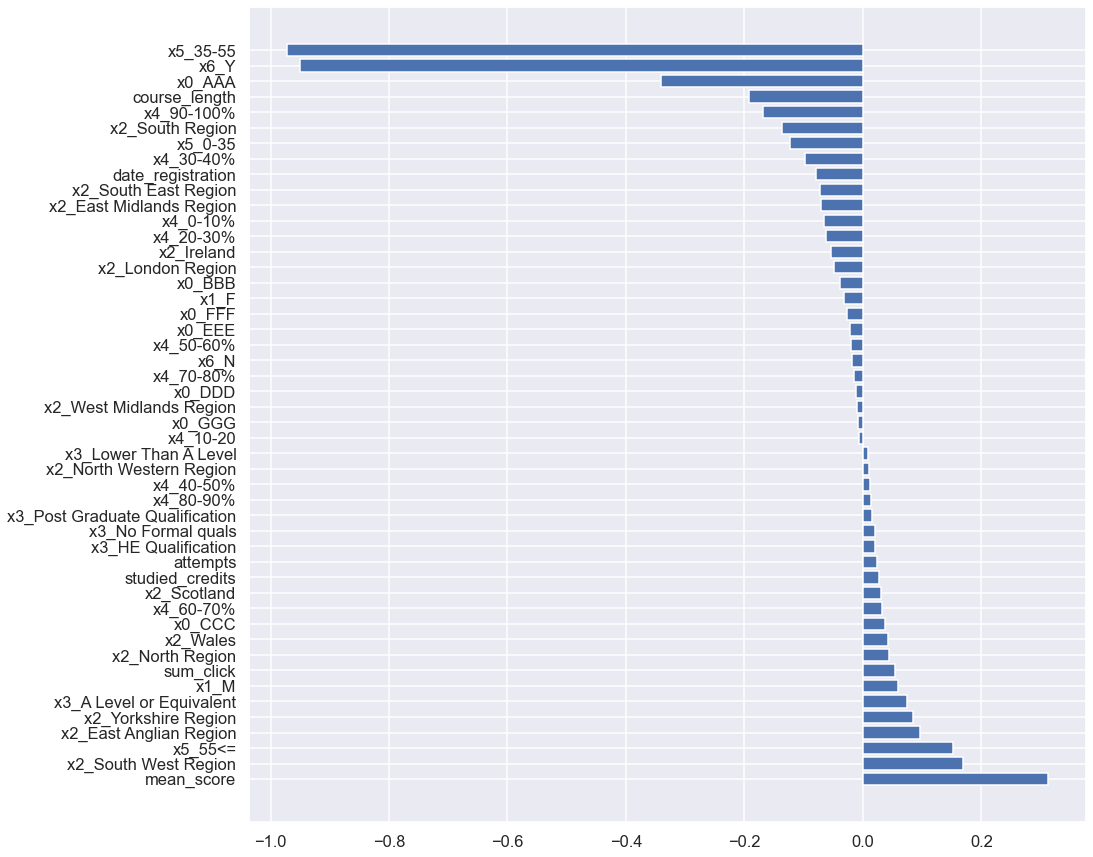

In [89]:
fig, ax = plt.subplots(figsize = (15,15))
ax.barh(width=feature_importance.importance, y=feature_importance.feature)

In [90]:
imp_features = feature_importance[(feature_importance['importance'] > 0)]
imp_features = imp_features['feature'].tolist()

## Random Forest Feature Importance

In [91]:
rf_permutation = permutation_importance(rf_pipeline, x_train, y_train)

In [92]:
rf_features = list(zip(x_train.columns, rf_permutation['importances_mean']))

In [93]:
rf_feature_importance = pd.DataFrame(rf_features, columns = ["feature", "importance"])

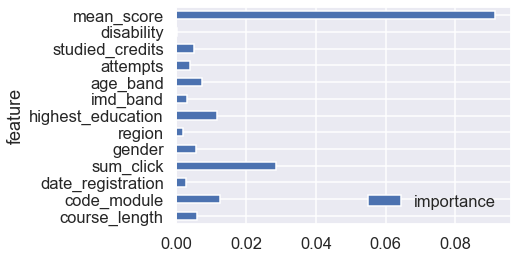

In [94]:
ax = rf_feature_importance.plot.barh(x='feature', y='importance')
plt.show()

# fig, ax = plt.subplots(figsize = (15,15))
# ax.barh(width=rf_feature_importance.importance, y=rf_feature_importance.feature)

## GridSearch for Best Model Parameters

In [95]:
models = {LR: {'C': [0.01, 0.02, 0.03, 0.05, 0.1, 0,2, 0.3, 0.5],
               'max_iter': [50, 100, 200, 500],
               'penalty': ['l2', 'l1', 'elasticnet', None],
               'solver': ['newton-cg', 'lbfgs', 'saga'], 
               'random_state': [2021]},
          KNN: {'metric': ['euclidean', 'manhattan'],
                'n_neighbors': [2, 3, 4, 5, 7, 10, 15],
                'weights': ['uniform', 'distance']},
          DT: {'criterion': ['gini', 'entropy'],
               'max_depth': [None, 4, 5, 7, 10],
               'min_samples_split': [2, 3, 5, 10],
               'random_state': [2021]}}
          

In [96]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    tuned_models = {}

    for model, params in models.items():
        pipe = make_pipeline(transformer, StandardScaler(with_mean = False),
                             SMOTE(),model())
    
        model_name = model.__name__.lower()
        parameters = dict(map(lambda x: (model_name +'__'+x[0], x[1]), params.items()))
    
        grid = GridSearchCV(pipe, parameters)
        grid.fit(x_train, y_train)
        tuned_models[model_name] = grid.best_estimator_.get_params()

In [97]:
tuned_models

{'logisticregression': {'memory': None,
  'steps': [('columntransformer',
    ColumnTransformer(remainder='passthrough',
                      transformers=[('categorical',
                                     OneHotEncoder(handle_unknown='ignore'),
                                     [1, 4, 5, 6, 7, 8, 11])])),
   ('standardscaler', StandardScaler(with_mean=False)),
   ('smote', SMOTE()),
   ('logisticregression',
    LogisticRegression(C=0.03, max_iter=500, random_state=2021, solver='saga'))],
  'verbose': False,
  'columntransformer': ColumnTransformer(remainder='passthrough',
                    transformers=[('categorical',
                                   OneHotEncoder(handle_unknown='ignore'),
                                   [1, 4, 5, 6, 7, 8, 11])]),
  'standardscaler': StandardScaler(with_mean=False),
  'smote': SMOTE(),
  'logisticregression': LogisticRegression(C=0.03, max_iter=500, random_state=2021, solver='saga'),
  'columntransformer__n_jobs': None,
  'columntransf

## Logistic Regression with Best Parameters

In [31]:
lr_best_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), LR(C=0.1, max_iter=500, random_state=2021, solver='saga'))

In [32]:
lr_best_pipe.fit(x_train, y_train)
lr_best_pipe.score(x_test, y_test)

0.738195302843016

In [33]:
history.report(lr_best_pipe,x_train, y_train, 'Logistic Regression - Best Params', 
               'Logistic Regression with GridSearched Parameters')

Average Accuracy Score: 0.734958528625231
Average Recall Score: 0.7098916779737375
Average Precision Score: 0.5182363611446851
Average F1 Score: 0.598991542113207


* **Predicted Values**

In [34]:
train_preds = lr_best_pipe.predict(x_train)
test_preds = lr_best_pipe.predict(x_test)

* **Evaluation Metrics**

In [35]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5221124946328897
Recall Score: 0.7182516243354992
Accuracy Score: 0.7379264875556288
F1 Score: 0.6046742913973148


Precision Score: 0.5242146596858639
Recall Score: 0.706972639011474
Accuracy Score: 0.738195302843016
F1 Score: 0.6020293122886133




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

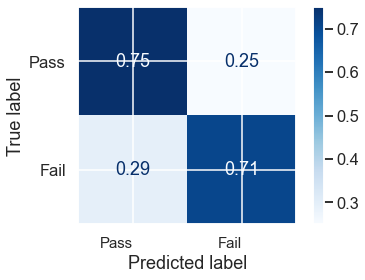

In [36]:
mf.confusion_mtx(lr_best_pipe, x_test, y_test)

## KNN with Best Parameters

In [104]:
knn_best_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), KNN(metric='manhattan', n_neighbors=2))

In [105]:
knn_best_pipe.fit(x_train, y_train)
knn_best_pipe.score(x_test, y_test)

0.6996291718170581

In [106]:
history.report(knn_best_pipe,x_train, y_train, 'KNN - Best Parameters', 
               'KNN with GridSearched Parameters')

Average Accuracy Score: 0.6902916102464921
Average Recall Score: 0.258793057457101
Average Precision Score: 0.4123111752653597
Average F1 Score: 0.31792222807901516


* **Predicted Values**

In [107]:
train_preds = knn_best_pipe.predict(x_train)
test_preds = knn_best_pipe.predict(x_test)

* **Evaluation Metrics**

In [108]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 1.0
Recall Score: 0.8083284111045481
Accuracy Score: 0.9465139278061645
F1 Score: 0.8940062061081169


Precision Score: 0.4415954415954416
Recall Score: 0.2736098852603707
Accuracy Score: 0.6996291718170581
F1 Score: 0.337874659400545




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

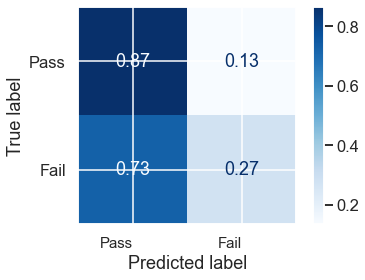

In [109]:
mf.confusion_mtx(knn_best_pipe, x_test, y_test)

## Decision Tree with Best Parameters

In [110]:
dt_best_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT(max_depth=7, min_samples_split=10, random_state=2021))

In [111]:
dt_best_pipe.fit(x_train, y_train)
dt_best_pipe.score(x_test, y_test)

0.7426452410383189

In [112]:
history.report(dt_best_pipe,x_train, y_train, 'DT - Best Parameters', 
               'DT with GridSearched Parameters')

Average Accuracy Score: 0.746990727850809
Average Recall Score: 0.6458060390345586
Average Precision Score: 0.5391095517186388
Average F1 Score: 0.5869414493969839


* **Predicted Values**

In [113]:
train_preds = dt_best_pipe.predict(x_train)
test_preds = dt_best_pipe.predict(x_test)

* **Evaluation Metrics**

In [114]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5635098185433756
Recall Score: 0.6695215593620791
Accuracy Score: 0.7630624690951047
F1 Score: 0.6119584289377784


Precision Score: 0.5350076103500762
Recall Score: 0.6204766107678729
Accuracy Score: 0.7426452410383189
F1 Score: 0.5745811197384553




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

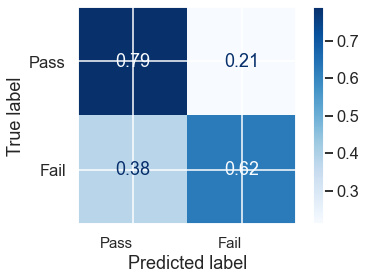

In [115]:
mf.confusion_mtx(dt_best_pipe, x_test, y_test)

### Results:

* Logistic Regression showed best results with grid serached parameters.
* The KNN and Decision Tree are overfitting training data

## Recursive Feature Selection for LR

In [116]:
from sklearn.feature_selection import RFE

In [117]:
lr_pipe_imp = make_pipeline(transformer, StandardScaler(with_mean = False), 
                            SMOTE(), RFE(estimator=LR(C=0.01, random_state=2021, max_iter = 5000), 
                                         n_features_to_select=22),
                            LR(C=0.01, random_state=2021, max_iter = 5000))

In [118]:
lr_pipe_imp.fit(x_train, y_train)

history.report(lr_pipe_imp,x_train, y_train, 'Linear Regression RFE Features', 
               'Linear Regression with RFE Features')

Average Accuracy Score: 0.733971486817033
Average Recall Score: 0.7085526146007758
Average Precision Score: 0.5168692941535973
Average F1 Score: 0.5976111953707781


In [119]:
train_preds = lr_pipe_imp.predict(x_train)
test_preds = lr_pipe_imp.predict(x_test)

In [120]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5189142979269075
Recall Score: 0.7170702894270525
Accuracy Score: 0.7355365089830229
F1 Score: 0.6021078735275884


Precision Score: 0.5189223861449648
Recall Score: 0.7140335392762577
Accuracy Score: 0.7344870210135971
F1 Score: 0.6010401188707282




<Figure size 720x720 with 0 Axes>

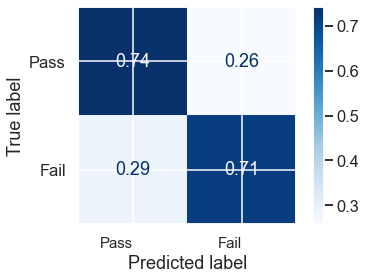

In [121]:
mf.confusion_mtx(lr_pipe_imp, x_test, y_test)

In [122]:
history.history

,Name,Accuracy_Score,Recall_Score,Precision_Score,F1_Score,Notes
0,KNN - Best Parameters,0.690292,0.258793,0.412311,0.317922,KNN with GridSearched Parameters
1,Logistic Regression,0.780453,0.398375,0.681953,0.502491,Regression with All Features and Imbalanced Data
2,XGBoost - Defaults,0.792320,0.524666,0.660285,0.584461,XGBoost with All Features
3,Decision Tree - Defaults,0.713616,0.562662,0.488562,0.522866,Decision Tree with All Features
4,KNN - Defaults,0.595678,0.577539,0.360191,0.443588,KNN with All Features
5,Gradient Boost - Depth 5,0.791907,0.582120,0.639406,0.609303,Gradient Boost with All Features and Depth 5
6,DT - Best Parameters,0.746991,0.645806,0.539110,0.586941,DT with GridSearched Parameters
7,Decision Tree - Depth 5,0.733063,0.645890,0.521908,0.574929,Decision Tree with Max Depth of 5
8,Random Forest - Depth 5,0.733476,0.653668,0.517596,0.577597,Random Forest with All Features and Depth 5
12,Linear Regression RFE Features,0.733971,0.708553,0.516869,0.597611,Linear Regression with RFE Features


# Modeling Results

Based on the **Recall and F1** Scores, the **Logistic Regression Model** with Grid Searched parameters has performed the best - **Recall(0.71), F1(0.59).** The **confusion matrix** shows **lowest values for false negative** predictions - predicting pass, while student is failing. I will **test the model on holdout data.** 

## Predicting on Holdout Data

In [37]:
train_preds = lr_best_pipe.predict(x_train)
hold_preds = lr_best_pipe.predict(x_hold)

In [38]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_hold,hold_preds)

Precision Score: 0.5221124946328897
Recall Score: 0.7182516243354992
Accuracy Score: 0.7379264875556288
F1 Score: 0.6046742913973148


Precision Score: 0.5089399744572158
Recall Score: 0.7400185701021356
Accuracy Score: 0.7406674907292954
F1 Score: 0.6031025349981082




<Figure size 720x720 with 0 Axes>

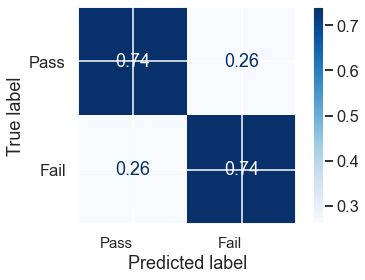

In [39]:
mf.confusion_mtx(lr_best_pipe, x_hold, y_hold)


In [40]:
x_one = x_hold[:1]
x_one

,course_length,code_module,date_registration,sum_click,gender,region,highest_education,imd_band,age_band,attempts,studied_credits,disability,mean_score
14449,234,BBB,29,418,F,Wales,Lower Than A Level,20-30%,0-35,0,120,N,83.6


In [42]:
pl = lr_best_pipe.predict(x_one)
pl[0]

1

### Results:

* Model showed better performance on holdout data than on test data. The value for false negatives on hold data is 0.25 based on confusion matrix.
* The recall score of 0.75 indicates that 75% of the results were predicted truly as Fail, and 0.50 precision indicates that 50% of final results were correctly predicted as Pass.

<Figure size 720x720 with 0 Axes>

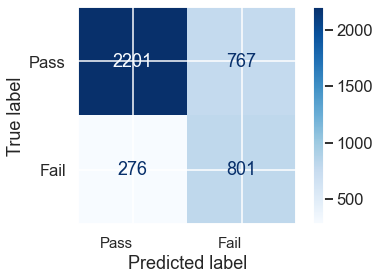

In [126]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(lr_best_pipe, x_hold, y_hold,
                     cmap=plt.cm.Blues, display_labels=
                          ['Pass', 'Fail'])

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [127]:
import joblib

filename = 'lr_model.pkl'
joblib.dump(lr_best_pipe, filename)

['lr_model.pkl']